## Musical Instrument Chord Classification

#### Imports

In [1]:
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
import pandas as pd
import os
import numpy as np
import seaborn as sns
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten
from keras.optimizers import Adam
from sklearn import metrics
from keras.callbacks import ModelCheckpoint
from datetime import datetime 
from keras import datasets, layers, models

#### Data Preparation

In [2]:
import librosa
audio_file_path='../Dataset/audio/Major/Major_4.wav'
librosa_audio_data,librosa_sample_rate=librosa.load(audio_file_path)

In [3]:
librosa_audio_data

array([-0.00360439, -0.00573094, -0.0050764 , ...,  0.        ,
       -0.        ,  0.        ], dtype=float32)

In [4]:
librosa_sample_rate

22050

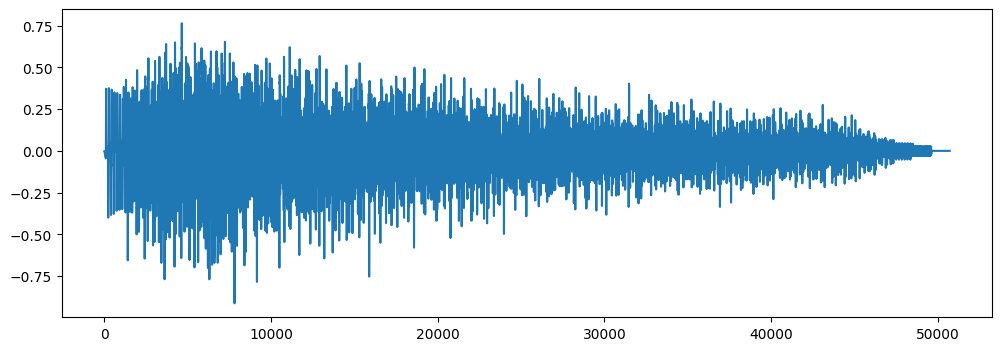

In [5]:
# Original audio with 1 channel 
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)

In [6]:
wave_sample_rate, wave_audio = wav.read(audio_file_path) 

In [7]:
wave_audio

array([-142, -193, -158, ...,    0,    0,    0], dtype=int16)

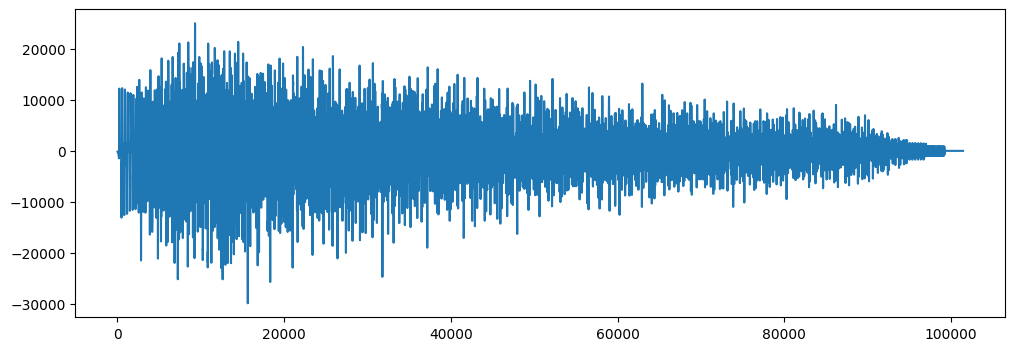

In [8]:
# Original audio with 2 channels 
plt.figure(figsize=(12, 4))
plt.plot(wave_audio)

In [9]:
data_dir = '../Dataset/audio'

file_paths = []
labels = []

for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for file_name in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file_name)
            file_paths.append(file_path)
            labels.append(label)

df = pd.DataFrame({'file_path': file_paths, 'label': labels})

In [10]:
df.head()

,file_path,label
0,../Dataset/audio/Major/4_21.wav,Major
1,../Dataset/audio/Major/1_8.wav,Major
2,../Dataset/audio/Major/Major_500.wav,Major
3,../Dataset/audio/Major/Major_266.wav,Major
4,../Dataset/audio/Major/Major_272.wav,Major


In [11]:
# count the number of samples for each label
df['label'].value_counts()

Major    753
Minor    610
Name: label, dtype: int64

<Axes: xlabel='label', ylabel='count'>

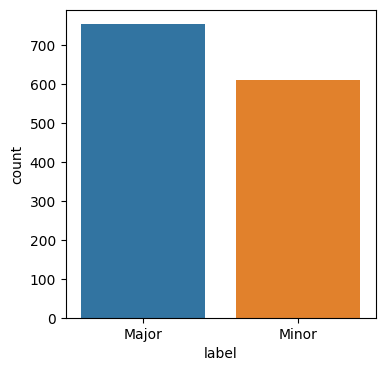

In [12]:
# countplot of labels with counts
plt.figure(figsize=(4, 4))
sns.countplot(x='label', data=df)

#### Feature Extraction

Here we will be using Mel-Frequency Cepstral Coefficients(MFCC) from the audio samples. The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification.

In [13]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 100)


In [14]:
mfccs

array([[-3.21483673e+02, -3.02592743e+02, -2.51817734e+02, ...,
        -4.01579620e+02, -4.88464569e+02, -6.33760742e+02],
       [ 2.69293976e+02,  2.71705231e+02,  2.74144165e+02, ...,
         1.25161591e+02,  1.15193275e+02,  0.00000000e+00],
       [ 2.40720940e+01,  8.46327496e+00, -1.82076969e+01, ...,
         3.89744854e+00,  1.01470566e+01,  0.00000000e+00],
       ...,
       [-1.39344013e+00, -4.51191854e+00, -5.17483997e+00, ...,
         5.48824596e+00,  2.36826587e+00,  0.00000000e+00],
       [-1.15002174e+01, -1.22891912e+01, -1.41595516e+01, ...,
         4.29746056e+00,  5.32274723e-01,  0.00000000e+00],
       [-1.92314072e+01, -1.58172750e+01, -5.91461372e+00, ...,
         3.72530890e+00,  5.37545443e-01,  0.00000000e+00]], dtype=float32)

In [15]:
def extract_features(audio_path, duration=2, sr=22050, n_mfcc=20):
    # Load the audio file
    audio, _ = librosa.load(audio_path, sr=sr, duration=duration)

    # Extract features using MFCC
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)

    # Concatenate the mean and standard deviation features
    features = np.concatenate((mfcc_mean, mfcc_std))

    return features
    

In [16]:
def preprocess_data(data_directory):
    # Initialize empty lists for features and labels
    features = []
    labels = []

    # Iterate through the class label directories
    for class_label in os.listdir(data_directory):
        class_directory = os.path.join(data_directory, class_label)

        # Iterate through the audio files in the class label directory
        for audio_file in os.listdir(class_directory):
            audio_path = os.path.join(class_directory, audio_file)

            # Extract features from the audio file
            audio_features = extract_features(audio_path)

            # Append the features and corresponding label to the lists
            features.append(audio_features)
            labels.append(class_label)

    # Convert the lists to NumPy arrays
    features = np.array(features)
    labels = np.array(labels)

    return features, labels

In [18]:
data_directory = "../Dataset/audio/"
features, labels = preprocess_data(data_directory)

features.shape

(1361, 40)

In [19]:
labels.shape

(1361,)

In [20]:
features[0]

array([-4.63807037e+02,  1.55907593e+02,  3.41423721e+01,  3.15320911e+01,
        2.54296322e+01, -2.84623981e+00, -1.27751589e+01, -1.09102497e+01,
       -1.41670866e+01, -2.93980446e+01, -2.96128044e+01, -1.46712799e+01,
       -1.33391533e+01, -1.91083317e+01, -1.04484320e+01, -2.00637028e-01,
       -6.86295795e+00, -1.31517372e+01, -1.16062355e+01, -1.38077669e+01,
        7.76390457e+01,  3.71505966e+01,  3.31891479e+01,  9.76270962e+00,
        5.95628691e+00,  9.26697063e+00,  8.19893265e+00,  6.64934349e+00,
        6.56440973e+00,  8.62963200e+00,  8.97558308e+00,  4.91507339e+00,
        5.74227142e+00,  8.62385654e+00,  7.64364624e+00,  4.09628916e+00,
        5.99119949e+00,  7.60266876e+00,  6.27624083e+00,  4.49545574e+00],
      dtype=float32)

In [21]:
# convert the features and corresponding labels to df
features_df = pd.DataFrame({'features': list(features), 'labels': labels})

In [22]:
features_df.head()

,features,labels
0,"[-463.80704, 155.9076, 34.142372, 31.532091, 2...",Major
1,"[-297.34857, 189.93884, 34.087513, 28.949303, ...",Major
2,"[-279.828, 233.99982, 3.321904, -5.1202745, 3....",Major
3,"[-241.15944, 236.79521, -7.730321, -4.8120694,...",Major
4,"[-250.74883, 240.53954, -6.1479445, -1.3055583...",Major


In [23]:
### Split the dataset into independent and dependent dataset
X=np.array(features_df['features'].tolist())
y=np.array(features_df['labels'].tolist())

In [24]:
# shape of independent and dependent dataset
X.shape, y.shape

((1361, 40), (1361,))

In [25]:
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [26]:
y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [65]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [66]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1088, 40), (273, 40), (1088, 2), (273, 2))

In [67]:
num_labels=y.shape[1]

In [68]:
# function to plote training history
def plot_history(history):
    # store results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # plot results
    # accuracy
    plt.figure(figsize=(5, 8))
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')
    
    # loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()

______

#### Approach 1: ANN

In [69]:
ann = models.Sequential([
    layers.Flatten(input_shape=(40,)),
    layers.Dense(5000, activation='relu'),
    layers.Dense(3000, activation='relu'),
    layers.Dense(1000, activation='relu'),
    layers.Dense(num_labels, activation='softmax')
])

In [70]:
ann.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 40)                0         
                                                                 
 dense_27 (Dense)            (None, 5000)              205000    
                                                                 
 dense_28 (Dense)            (None, 3000)              15003000  
                                                                 
 dense_29 (Dense)            (None, 1000)              3001000   
                                                                 
 dense_30 (Dense)            (None, 2)                 2002      
                                                                 
Total params: 18211002 (69.47 MB)
Trainable params: 18211002 (69.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [71]:
ann.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [72]:
num_epochs = 100
num_batch_size = 32

# checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
#                                verbose=1, save_best_only=True)

start = datetime.now()

ann.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
 4/34 [==>...........................] - ETA: 0s - loss: 128.4004 - accuracy: 0.4609

2023-07-06 14:01:38.085895: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-07-06 14:01:38.092438: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


34/34 [==============================] - 1s 26ms/step - loss: 17.6516 - accuracy: 0.4982 - val_loss: 0.6894 - val_accuracy: 0.5788
Epoch 2/100
 4/34 [==>...........................] - ETA: 0s - loss: 1.0251 - accuracy: 0.5156

2023-07-06 14:01:38.922190: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-07-06 14:01:38.925474: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


34/34 [==============================] - 1s 24ms/step - loss: 0.8269 - accuracy: 0.5404 - val_loss: 0.8725 - val_accuracy: 0.5421
Epoch 3/100
34/34 [==============================] - 1s 25ms/step - loss: 0.8546 - accuracy: 0.5469 - val_loss: 0.6873 - val_accuracy: 0.5714
Epoch 4/100
34/34 [==============================] - 1s 21ms/step - loss: 0.7132 - accuracy: 0.5763 - val_loss: 0.6575 - val_accuracy: 0.5971
Epoch 5/100
34/34 [==============================] - 1s 21ms/step - loss: 0.7768 - accuracy: 0.5910 - val_loss: 0.6581 - val_accuracy: 0.6081
Epoch 6/100
34/34 [==============================] - 1s 21ms/step - loss: 0.6520 - accuracy: 0.6112 - val_loss: 0.6219 - val_accuracy: 0.6154
Epoch 7/100
34/34 [==============================] - 1s 21ms/step - loss: 0.6375 - accuracy: 0.6397 - val_loss: 0.6423 - val_accuracy: 0.6154
Epoch 8/100
34/34 [==============================] - 1s 21ms/step - loss: 0.6092 - accuracy: 0.6461 - val_loss: 0.6136 - val_accuracy: 0.6520
Epoch 9/100
34/34 

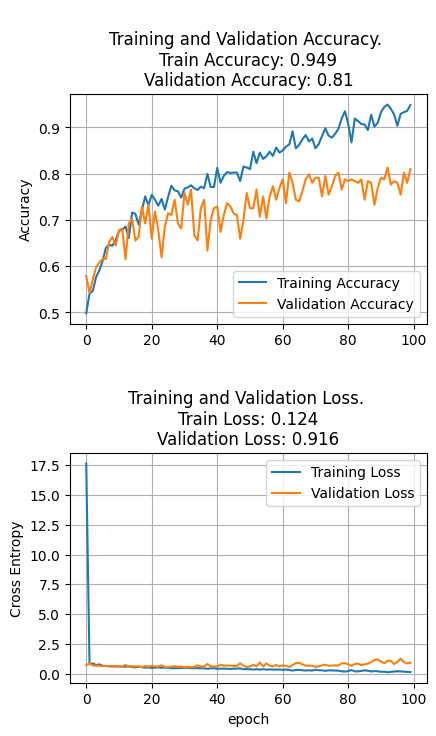

In [73]:
plot_history(ann.history)

_______

#### Approach 2: CNN

In [74]:
model=Sequential()
###first layer
model.add(Dense(1000,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(2000))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [75]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 1000)              41000     
                                                                 
 activation_8 (Activation)   (None, 1000)              0         
                                                                 
 dropout_6 (Dropout)         (None, 1000)              0         
                                                                 
 dense_32 (Dense)            (None, 2000)              2002000   
                                                                 
 activation_9 (Activation)   (None, 2000)              0         
                                                                 
 dropout_7 (Dropout)         (None, 2000)              0         
                                                                 
 dense_33 (Dense)            (None, 1000)             

In [76]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [77]:
num_epochs = 100
num_batch_size = 32

# checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
#                                verbose=1, save_best_only=True)

start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
 6/34 [====>.........................] - ETA: 0s - loss: 45.7380 - accuracy: 0.4844

2023-07-06 14:02:52.110438: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-07-06 14:02:52.118121: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


34/34 [==============================] - 1s 17ms/step - loss: 17.2057 - accuracy: 0.5055 - val_loss: 0.8192 - val_accuracy: 0.5348
Epoch 2/100
 6/34 [====>.........................] - ETA: 0s - loss: 2.0462 - accuracy: 0.4740

2023-07-06 14:02:52.649265: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-07-06 14:02:52.652628: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


34/34 [==============================] - 0s 13ms/step - loss: 1.4287 - accuracy: 0.4816 - val_loss: 0.6884 - val_accuracy: 0.5385
Epoch 3/100
34/34 [==============================] - 0s 13ms/step - loss: 0.9817 - accuracy: 0.5267 - val_loss: 0.7151 - val_accuracy: 0.4579
Epoch 4/100
34/34 [==============================] - 0s 13ms/step - loss: 0.8308 - accuracy: 0.5322 - val_loss: 0.6831 - val_accuracy: 0.5678
Epoch 5/100
34/34 [==============================] - 0s 13ms/step - loss: 0.7839 - accuracy: 0.5276 - val_loss: 0.6915 - val_accuracy: 0.5128
Epoch 6/100
34/34 [==============================] - 0s 13ms/step - loss: 0.7439 - accuracy: 0.5597 - val_loss: 0.6885 - val_accuracy: 0.5568
Epoch 7/100
34/34 [==============================] - 0s 13ms/step - loss: 0.7485 - accuracy: 0.5579 - val_loss: 0.6933 - val_accuracy: 0.4689
Epoch 8/100
34/34 [==============================] - 0s 13ms/step - loss: 0.7313 - accuracy: 0.5377 - val_loss: 0.6854 - val_accuracy: 0.5788
Epoch 9/100
34/34 

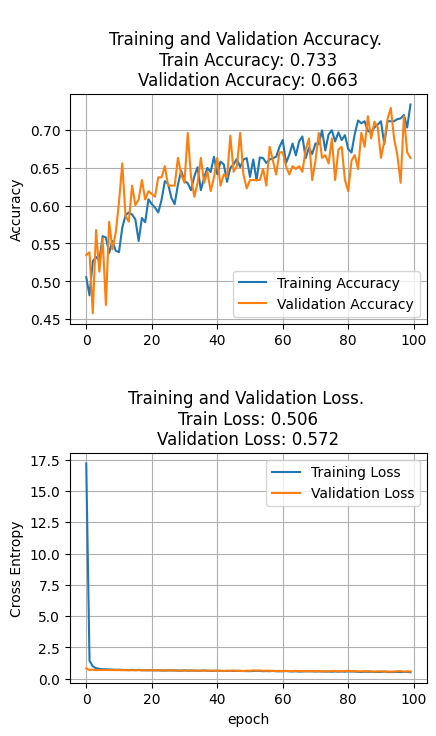

In [78]:
plot_history(model.history)

__________

#### Approach 3: MLP

In [79]:
model = Sequential([
    layers.Dense(64, activation='relu', input_dim=40),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(2, activation='softmax')
])

In [80]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [81]:
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
 7/34 [=====>........................] - ETA: 0s - loss: 11.9131 - accuracy: 0.4018

2023-07-06 14:03:38.752279: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-07-06 14:03:38.759409: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


34/34 [==============================] - 1s 12ms/step - loss: 3.6740 - accuracy: 0.5055 - val_loss: 0.9307 - val_accuracy: 0.4945
Epoch 2/100
11/34 [========>.....................] - ETA: 0s - loss: 0.8721 - accuracy: 0.5653

2023-07-06 14:03:39.135924: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-07-06 14:03:39.139544: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


34/34 [==============================] - 0s 7ms/step - loss: 0.7958 - accuracy: 0.5689 - val_loss: 0.7484 - val_accuracy: 0.6044
Epoch 3/100
34/34 [==============================] - 0s 7ms/step - loss: 0.7732 - accuracy: 0.5588 - val_loss: 0.7052 - val_accuracy: 0.5897
Epoch 4/100
34/34 [==============================] - 0s 6ms/step - loss: 0.7443 - accuracy: 0.5708 - val_loss: 0.7344 - val_accuracy: 0.5568
Epoch 5/100
34/34 [==============================] - 0s 6ms/step - loss: 0.7339 - accuracy: 0.5616 - val_loss: 0.7801 - val_accuracy: 0.5092
Epoch 6/100
34/34 [==============================] - 0s 6ms/step - loss: 0.6911 - accuracy: 0.6176 - val_loss: 0.6656 - val_accuracy: 0.6044
Epoch 7/100
34/34 [==============================] - 0s 6ms/step - loss: 0.6718 - accuracy: 0.5983 - val_loss: 0.7661 - val_accuracy: 0.5861
Epoch 8/100
34/34 [==============================] - 0s 6ms/step - loss: 0.6687 - accuracy: 0.6039 - val_loss: 0.7070 - val_accuracy: 0.5971
Epoch 9/100
34/34 [======

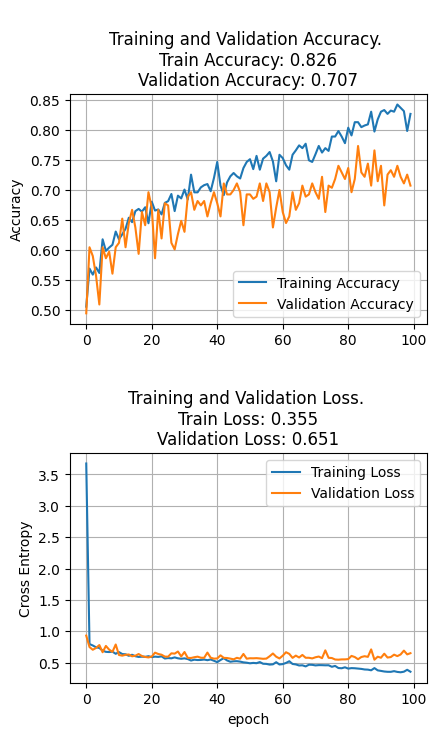

In [82]:
plot_history(model.history)